In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors

%matplotlib inline

In [2]:
plt.style.use('dark_background')

In [18]:
plt.style.use('default')

# Xenium Analysis

In [23]:
c3m1_cells = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\xenium_prerelease_molina_mouse_brain_Mar13\C3m1\cells.csv.gz")
c3m1_cells

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,total_counts,cell_area,nucleus_area
0,1,1470.409833,4249.051636,4,0,0,0,4,178.186563,44.704687
1,2,1474.557941,4239.123071,12,0,0,0,12,50.439531,29.487031
2,3,1474.138440,4230.722266,34,0,0,0,34,251.430000,54.639063
3,4,1479.313043,4242.560010,3,0,0,0,3,50.665312,23.345781
4,5,1486.422662,4240.159839,6,0,0,0,6,59.199844,29.712812
...,...,...,...,...,...,...,...,...,...,...
52519,52520,5460.260132,4814.415771,51,0,0,0,51,134.114063,14.811250
52520,52521,5464.195117,4851.216040,196,0,0,0,196,359.443750,47.775313
52521,52522,5464.681958,4790.854834,430,0,0,1,431,740.065781,47.323750
52522,52523,5483.099731,4832.196875,161,1,0,0,162,386.221406,17.249688


In [24]:
sample_id_list = ['C3m1', 'C3m2', 'C3m3', 'C24m1', 'C24m2', 'C24m3', 'HD24m1', 'HD24m2', 'HD24m3', 'R61']

In [29]:
concated_cell_csv = pd.DataFrame()
for sample_id in sample_id_list:
    df = pd.read_csv(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\xenium_prerelease_molina_mouse_brain_Mar13\{sample_id}\cells.csv.gz")
    df['sample_id'] = sample_id
    concated_cell_csv = pd.concat([concated_cell_csv, df])

In [32]:
xenium_transcripts = concated_cell_csv['total_counts']
xenium_transcripts

0         4
1        12
2        34
3         3
4         6
         ..
62710     4
62711     0
62712     2
62713     1
62714     2
Name: total_counts, Length: 556343, dtype: int64

In [109]:
print(f'Xenium mean transcript count: {xenium_transcripts.mean()}')
print(f'Xenium standard deviation transcript count: {xenium_transcripts.std()}')
print(f'Xenium max transcript count: {xenium_transcripts.max()}')

Xenium mean transcript count: 207.7140433150053
Xenium standard deviation transcript count: 138.7766112726301
Xenium max transcript count: 1529


Text(0.5, 1.0, 'Xenium - Number of transcripts per cell')

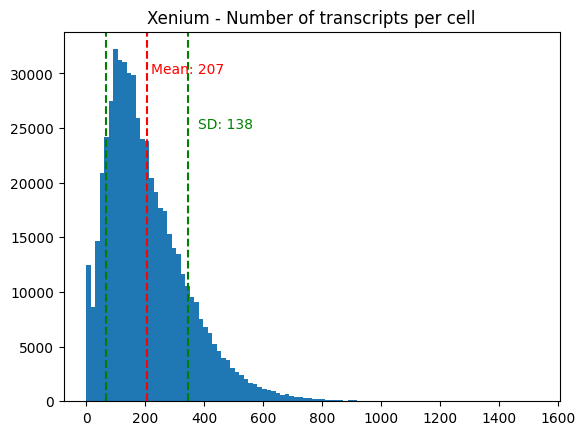

In [34]:
plt.hist(xenium_transcripts, bins = 100)
plt.axvline(xenium_transcripts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(220, 30000, f'Mean: {int(xenium_transcripts.mean())}', color = 'red')
plt.axvline(xenium_transcripts.mean() - xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(380, 25000, f'SD: {int(xenium_transcripts.std())}', color = 'green')
plt.axvline(xenium_transcripts.mean() + xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Xenium - Number of transcripts per cell')

# Cosmx analysis

In [66]:
cosmx_gene_exp = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\5 Raw data\MsBrain_exprMat_file.csv")
cosmx_gene_exp = cosmx_gene_exp.drop(columns = ['fov', 'cell_ID'])
cosmx_gene_exp

,Chrna4,Slc6a1,Cd109,Ldha,Aldoc,Drd1,Tank,Rit2,Prkag2,Lpar3,...,NegPrb1,NegPrb2,NegPrb3,NegPrb4,NegPrb5,NegPrb6,NegPrb7,NegPrb8,NegPrb9,NegPrb10
0,6,19,11,27,106,17,15,14,6,8,...,3,1,6,6,7,14,1,8,5,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134768,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134770,0,1,0,0,3,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
134771,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
cosmx_gene_exp_revised = cosmx_gene_exp.iloc[:, :-10]
cosmx_transcript_counts = cosmx_gene_exp_revised.sum(axis = 1)
cosmx_transcript_counts

0         17818
1             0
2            14
3            26
4            12
          ...  
134768       60
134769       42
134770      308
134771      108
134772      200
Length: 134773, dtype: int64

In [110]:
print(f'Cosmx mean transcript count: {cosmx_transcript_counts.mean()}')
print(f'Cosmx standard deviation transcript count: {cosmx_transcript_counts.std()}')
print(f'Cosmx max transcript count: {cosmx_transcript_counts.max()}')

Cosmx mean transcript count: 524.3128445608542
Cosmx standard deviation transcript count: 2338.775609728052
Cosmx max transcript count: 129447


Text(0.5, 1.0, 'Cosmx - Number of transcripts per cell')

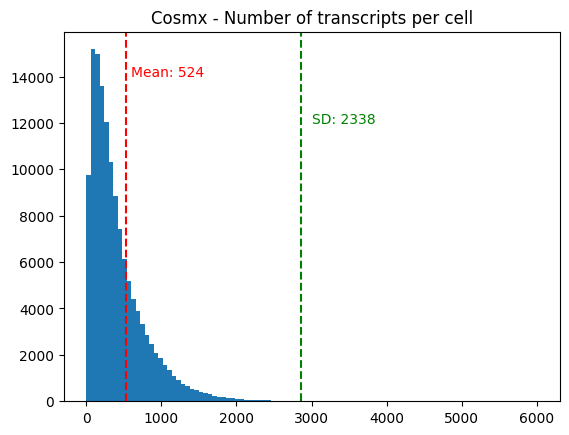

In [111]:
plt.hist(cosmx_transcript_counts, bins = 100, range = (0, 6000))
plt.axvline(cosmx_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(600, 14000, f'Mean: {int(cosmx_transcript_counts.mean())}', color = 'red')
#plt.axvline(cosmx_transcript_counts.mean() - cosmx_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(3000, 12000, f'SD: {int(cosmx_transcript_counts.std())}', color = 'green')
plt.axvline(cosmx_transcript_counts.mean() + cosmx_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cosmx - Number of transcripts per cell')

# Vizgen analysis

In [122]:
region_list = ['Region 0', 'Region 1', 'Region 2', 'Region 3']

In [124]:
vizgen_concat = pd.DataFrame()
for region in region_list:
    df = pd.read_csv(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Vizgen Analysis\{region}\detected_transcripts.csv")
    df['sample_id'] = region
    df_revised = df[df['cell_id'] != -1]
    df_revised1 = df_revised.groupby(['cell_id','gene']).count()[['transcript_id']].reset_index()
    gene_exp = df_revised1.pivot_table(index='cell_id', columns='gene', values='transcript_id', fill_value=0)
    vizgen_concat = pd.concat([vizgen_concat, gene_exp])

In [129]:
vizgen_transcript_counts = vizgen_concat.sum(axis=1)
vizgen_transcript_counts

cell_id
4407145100026100001     2
4407145100026100002     3
4407145100026100003    26
4407145100026100012     2
4407145100026100014     1
                       ..
4407145601700100052     1
4407145601700100065     1
4407145601701100007     1
4407145601703100144     1
4407145601704100128     1
Length: 395424, dtype: int64

In [130]:
print(f'Vizgen mean transcript count: {vizgen_transcript_counts.mean()}')
print(f'Vizgen standard deviation transcript count: {vizgen_transcript_counts.std()}')
print(f'Vizgen max transcript count: {vizgen_transcript_counts.max()}')

Vizgen mean transcript count: 151.59098587844946
Vizgen standard deviation transcript count: 258.38750025655287
Vizgen max transcript count: 9458


Text(0.5, 1.0, 'Vizgen - Number of transcripts per cell')

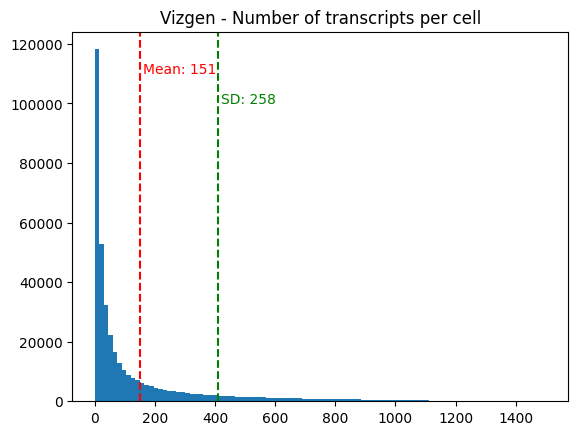

In [135]:
plt.hist(vizgen_transcript_counts, bins = 100, range = (0,1500))
plt.axvline(vizgen_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(160, 110000, f'Mean: {int(vizgen_transcript_counts.mean())}', color = 'red')
#plt.axvline(vizgen_transcript_counts.mean() - vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(420, 100000, f'SD: {int(vizgen_transcript_counts.std())}', color = 'green')
plt.axvline(vizgen_transcript_counts.mean() + vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Vizgen - Number of transcripts per cell')

# Number of genes in each method

In [141]:
xenium_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Xenium_mouse_filtered.h5ad")
xenium_scdata

AnnData object with n_obs × n_vars = 547139 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names'
    uns: 'Sample ID_colors', 'cell_id_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [143]:
len(xenium_scdata.var)

248

In [140]:
print (f'Xenium gene panel size: {len(xenium_scdata.var)}')
print (f'Cosmx gene panel size: {cosmx_gene_exp_revised.shape[1]}')
print (f'Vizgen gene panel size: {vizgen_concat.shape[1]}')

Cosmx gene panel size: 950
Vizgen gene panel size: 550
